# Simple Dadi Parameter Analysis

This notebook provides a straightforward analysis of dadi optimization results, comparing ground truth parameters with estimated values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pathlib import Path
import warnings
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
warnings.filterwarnings('ignore')

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Configuration - UPDATE THESE PATHS FOR YOUR EXPERIMENT
EXPERIMENT_NAME = 'drosophila_three_epoch'  # Change this to your experiment
BASE_PATH = Path(f'/projects/kernlab/akapoor/Infer_Demography/experiments/{EXPERIMENT_NAME}')
SIMULATIONS_PATH = BASE_PATH / 'simulations'
RUNS_PATH = BASE_PATH / 'runs'

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Simulations path: {SIMULATIONS_PATH}")
print(f"Runs path: {RUNS_PATH}")
print(f"Paths exist: {SIMULATIONS_PATH.exists()}, {RUNS_PATH.exists()}")

Experiment: drosophila_three_epoch
Simulations path: /projects/kernlab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/simulations
Runs path: /projects/kernlab/akapoor/Infer_Demography/experiments/drosophila_three_epoch/runs
Paths exist: True, True


In [3]:
# ----------------------------
# Fast directory iteration
# ----------------------------
def _iter_subdirs(path: Path):
    """Yield immediate subdirectories of path using os.scandir (fast)."""
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                yield Path(entry.path)

def _safe_load_pickle(path: Path):
    try:
        with open(path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        return e  # return exception object; caller decides how to handle

def _safe_load_json(path: Path):
    try:
        with open(path, "r") as f:
            return json.load(f)
    except Exception as e:
        return e


# ----------------------------
# One-pass loader for simulations/
# ----------------------------
def load_simulation_metadata(simulations_path: Path, *, max_workers: int = 32, verbose: bool = True):
    """
    One traversal of simulations_path that loads:
      - sampled_params.pkl (ground truth)
      - bgs.meta.json (coverage)
    in parallel.

    Returns:
      ground_truth: dict[sim_id -> params_dict]
      coverage_data: dict[sim_id -> float|None]
    """
    sim_dirs = list(_iter_subdirs(simulations_path))

    ground_truth = {}
    coverage_data = {}

    # Prepare tasks
    tasks = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for sim_dir in sim_dirs:
            sim_id = sim_dir.name
            # initialize coverage to None so you always have a key
            coverage_data[sim_id] = None

            param_file = sim_dir / "sampled_params.pkl"
            meta_file  = sim_dir / "bgs.meta.json"

            # Submit loads only if file exists (one stat each; ok)
            if param_file.is_file():
                tasks.append(("pkl", sim_id, param_file, ex.submit(_safe_load_pickle, param_file)))
            if meta_file.is_file():
                tasks.append(("json", sim_id, meta_file, ex.submit(_safe_load_json, meta_file)))

        # Collect results
        for kind, sim_id, path, fut in tasks:
            out = fut.result()
            if isinstance(out, Exception):
                if verbose:
                    print(f"Error loading {path}: {out}")
                continue

            if kind == "pkl":
                ground_truth[sim_id] = out
            else:
                coverage_data[sim_id] = out.get("sampled_coverage_percent", None)

    if verbose:
        print(f"Loaded ground truth for {len(ground_truth)} simulations")
        valid_coverage = sum(v is not None for v in coverage_data.values())
        print(f"Loaded coverage data for {len(coverage_data)} simulations")
        print(f"  {valid_coverage} simulations have coverage data")

    return ground_truth, coverage_data


# ----------------------------
# Faster dadi results loader (threaded + less filesystem overhead)
# ----------------------------
def _parse_run_dir_name(name: str):
    # expected: run_<sim>_<rep>
    parts = name.split("_")
    if len(parts) >= 3 and parts[0] == "run":
        return parts[1], parts[2]
    return None, None

def load_dadi_results(runs_path: Path, *, max_workers: int = 32, verbose: bool = True):
    """
    Loads one dadi result file per run directory, in parallel.
    """
    candidates = [
        "best_fit.pkl",
        "results.pkl",
        "optimization_results.pkl",
        "dadi_results.pkl",
    ]

    results = {}
    tasks = []

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for run_dir in _iter_subdirs(runs_path):
            sim_id, rep_id = _parse_run_dir_name(run_dir.name)
            if sim_id is None:
                continue

            dadi_dir = run_dir / "inferences" / "dadi"
            if not dadi_dir.is_dir():
                continue

            # Find the first existing file WITHOUT building a big list + sorting
            chosen = None
            for fname in candidates:
                p = dadi_dir / fname
                if p.is_file():
                    chosen = p
                    break
            if chosen is None:
                continue

            tasks.append((sim_id, rep_id, chosen, ex.submit(_safe_load_pickle, chosen)))

        for sim_id, rep_id, path, fut in tasks:
            out = fut.result()
            if isinstance(out, Exception):
                if verbose:
                    print(f"Error loading {path}: {out}")
                continue

            results.setdefault(sim_id, {})[rep_id] = out

    if verbose:
        print(f"Loaded dadi results for {len(results)} simulations")
    return results


# ----------------------------
# Keep your extractor (mostly CPU, not I/O bound)
# ----------------------------
def extract_parameters(dadi_data):
    params = {}
    likelihood = None

    if isinstance(dadi_data, dict):
        if "best_params" in dadi_data:
            bp = dadi_data["best_params"]
            if isinstance(bp, dict):
                params = bp
            elif "param_order" in dadi_data or "param_names" in dadi_data:
                order_key = "param_order" if "param_order" in dadi_data else "param_names"
                order = dadi_data[order_key]
                values = bp
                if len(order) == len(values):
                    params = dict(zip(order, values))

        for key in ["optimal_params", "parameters", "params", "popt"]:
            if key in dadi_data and not params:
                val = dadi_data[key]
                if isinstance(val, dict):
                    params = val
                elif isinstance(val, (list, tuple, np.ndarray)):
                    for name_key in ["param_order", "param_names", "parameter_names"]:
                        if name_key in dadi_data:
                            names = dadi_data[name_key]
                            if len(names) == len(val):
                                params = dict(zip(names, val))
                                break

        for key in ["best_ll", "log_likelihood", "ll", "likelihood", "best_likelihood", "logL"]:
            if key in dadi_data:
                val = dadi_data[key]
                likelihood = val[0] if isinstance(val, (list, tuple)) else val
                break

    if likelihood is not None:
        params["log_likelihood"] = float(likelihood)

    return params

print("Helper functions defined!")


Helper functions defined!


In [4]:
import time

t0 = time.time()
print("Loading ground truth + coverage (single pass)...")
ground_truth, coverage_data = load_simulation_metadata(SIMULATIONS_PATH, max_workers=32, verbose=True)
print(f"Done in {time.time() - t0:.2f}s")

t0 = time.time()
print("\nLoading dadi results...")
dadi_results = load_dadi_results(RUNS_PATH, max_workers=32, verbose=True)
print(f"Done in {time.time() - t0:.2f}s")

# Show example data (same as before, but a bit safer)
if ground_truth:
    first_sim = next(iter(ground_truth))
    print(f"\nExample ground truth parameters (sim {first_sim}):")
    for k, v in ground_truth[first_sim].items():
        print(f"  {k}: {v}")

if coverage_data:
    print("\nExample coverage data:")
    for sim_id in list(coverage_data.keys())[:5]:
        cov = coverage_data[sim_id]
        print(f"  Sim {sim_id}: {cov}% coverage" if cov is not None else f"  Sim {sim_id}: No coverage data")

if dadi_results:
    first_sim = next(iter(dadi_results))
    first_rep = next(iter(dadi_results[first_sim]))
    example_params = extract_parameters(dadi_results[first_sim][first_rep])
    print(f"\nExample estimated parameters (sim {first_sim}, rep {first_rep}):")
    for k, v in example_params.items():
        print(f"  {k}: {v}")


Loading ground truth + coverage (single pass)...
Loaded ground truth for 5000 simulations
Loaded coverage data for 5000 simulations
  5000 simulations have coverage data
Done in 8.81s

Loading dadi results...
Loaded dadi results for 5000 simulations
Done in 1168.07s

Example ground truth parameters (sim 705):
  N0: 17740.592810301212
  AFR: 27764.82609339578
  EUR_bottleneck: 856.1670545007102
  EUR_recover: 19096.66109791088
  T_AFR_expansion: 79102.80259847143
  T_AFR_EUR_split: 35845.02386970234
  T_EUR_expansion: 7565.857584458824

Example coverage data:
  Sim 705: 50.88515026491788% coverage
  Sim 3271: 79.27410639266816% coverage
  Sim 2097: 61.96823223489851% coverage
  Sim 338: 73.90358439954316% coverage
  Sim 3505: 54.250596153784144% coverage

Example estimated parameters (sim 457, rep 65):
  N0: 5843.107700856195
  AFR: 4999.999999999999
  EUR_bottleneck: 4999.9999999999945
  EUR_recover: 1935.0860580283165
  T_AFR_expansion: 194271.20098227676
  T_AFR_EUR_split: 17132.6767

In [5]:
# Create comparison dataframe
comparison_data = []

for sim_id in ground_truth.keys():
    if sim_id not in dadi_results:
        continue
        
    gt_params = ground_truth[sim_id]
    coverage = coverage_data.get(sim_id, None)  # Get coverage for this simulation
    
    for rep_id, rep_data in dadi_results[sim_id].items():
        est_params = extract_parameters(rep_data)
        
        # Find common parameters
        common_params = set(gt_params.keys()) & set(est_params.keys())
        common_params.discard('log_likelihood')  # Don't compare likelihood
        
        for param in common_params:
            gt_val = gt_params[param]
            est_val = est_params[param]
            
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': param,
                'ground_truth': gt_val,
                'estimated': est_val,
                'absolute_error': est_val - gt_val,
                'relative_error': (est_val - gt_val) / gt_val if gt_val != 0 else np.nan,
                'coverage_percent': coverage
            })
        
        # Add likelihood separately
        if 'log_likelihood' in est_params:
            comparison_data.append({
                'simulation': sim_id,
                'replicate': rep_id,
                'parameter': 'log_likelihood',
                'ground_truth': np.nan,
                'estimated': est_params['log_likelihood'],
                'absolute_error': np.nan,
                'relative_error': np.nan,
                'coverage_percent': coverage
            })

df = pd.DataFrame(comparison_data)
print(f"Created comparison dataframe with {len(df)} rows")
print(f"Parameters: {sorted(df['parameter'].unique())}")
print(f"Simulations: {len(df['simulation'].unique())}")

# Check coverage data distribution
if not df.empty:
    coverage_stats = df['coverage_percent'].describe()
    print(f"\nCoverage percentage statistics:")
    print(coverage_stats)
    
    # Show first few rows
    display(df.head(10))
else:
    print("\nNo data found! Check that dadi results exist and parameter names match.")

Created comparison dataframe with 3947424 rows
Parameters: ['AFR', 'EUR_bottleneck', 'EUR_recover', 'N0', 'T_AFR_EUR_split', 'T_AFR_expansion', 'T_EUR_expansion', 'log_likelihood']
Simulations: 5000

Coverage percentage statistics:
count    3.947424e+06
mean     4.747777e+01
std      2.719833e+01
min      1.019274e+00
25%      2.390628e+01
50%      4.713114e+01
75%      7.098342e+01
max      9.498879e+01
Name: coverage_percent, dtype: float64


simulation replicate        parameter  ground_truth      estimated  \
0        705        71  T_AFR_expansion  79102.802598   79102.802598   
1        705        71  T_EUR_expansion   7565.857584    1277.700646   
2        705        71              AFR  27764.826093   17982.973606   
3        705        71  T_AFR_EUR_split  35845.023870   27314.505992   
4        705        71      EUR_recover  19096.661098    1000.000000   
5        705        71   EUR_bottleneck    856.167055     852.816707   
6        705        71               N0  17740.592810   10947.020000   
7        705        71   log_likelihood           NaN  304293.575369   
8        705        23  T_AFR_expansion  79102.802598   79102.802598   
9        705        23  T_EUR_expansion   7565.857584    1246.967994   

   absolute_error  relative_error  coverage_percent  
0   -2.910383e-11   -3.679241e-16          50.88515  
1   -6.288157e+03   -8.311228e-01          50.88515  
2   -9.781852e+03   -3.523110e-01          50.88515  
3   -8.530518e+03   -2.379833e-01          50.88515  
4   -1.809666e+04   -9.476348e-01          50.88515  
5   -3.350348e+00   -3.913194e-03          50.88515  
6   -6.793573e+03   -3.829394e-01          50.88515  
7             NaN             NaN          50.88515  
8   -2.910383e-11   -3.679241e-16          50.88515  
9   -6.318890e+03   -8.351848e-01          50.88515

Plotting 7 parameters: ['T_AFR_expansion', 'T_EUR_expansion', 'AFR', 'T_AFR_EUR_split', 'EUR_recover', 'EUR_bottleneck', 'N0']


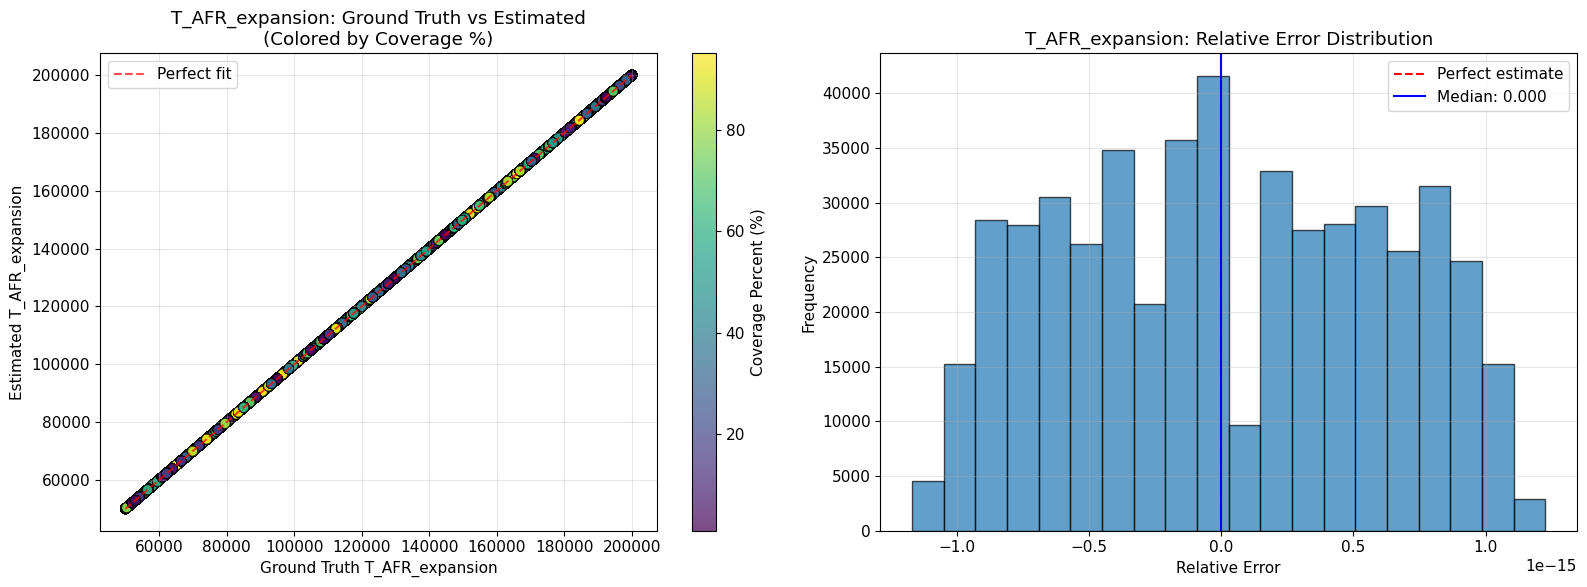


T_AFR_expansion Statistics:
  Estimates: 493428
  Correlation: 1.0000
  RMSE: 0.0000
  Mean relative error: 0.0000
  Std relative error: 0.0000
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




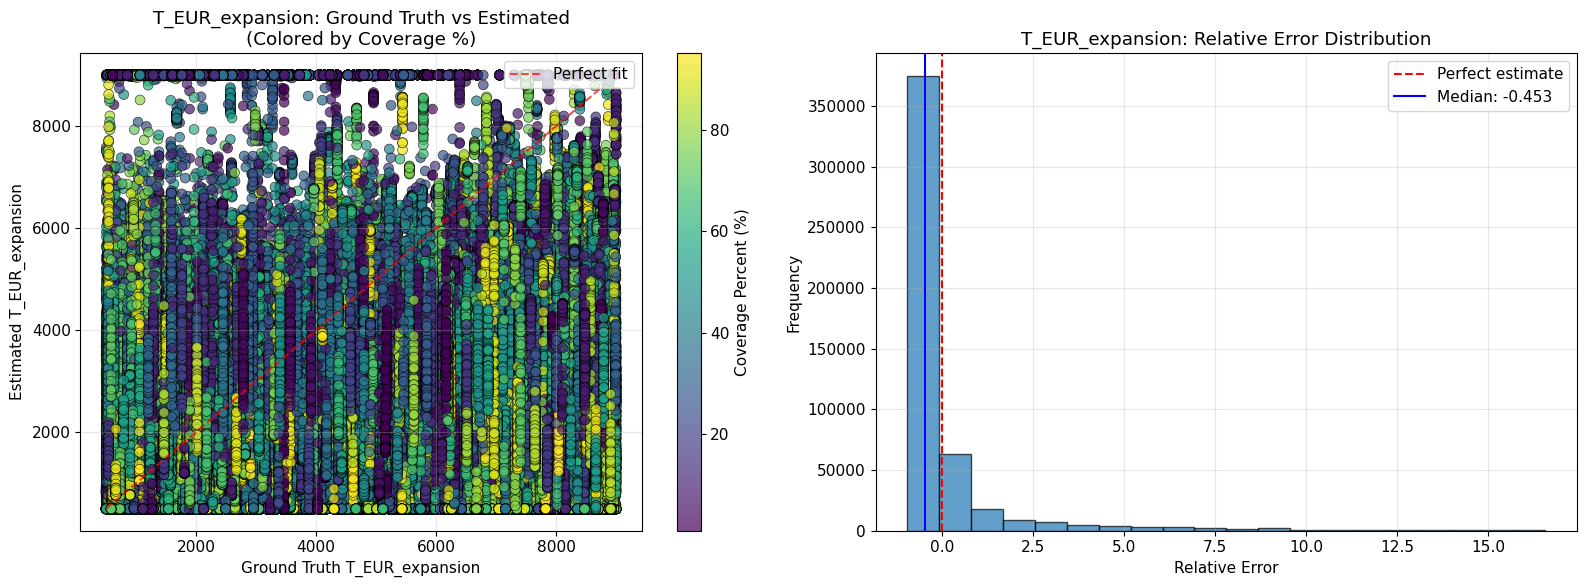


T_EUR_expansion Statistics:
  Estimates: 493428
  Correlation: -0.0606
  RMSE: 3798.4700
  Mean relative error: 0.0586
  Std relative error: 1.8473
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




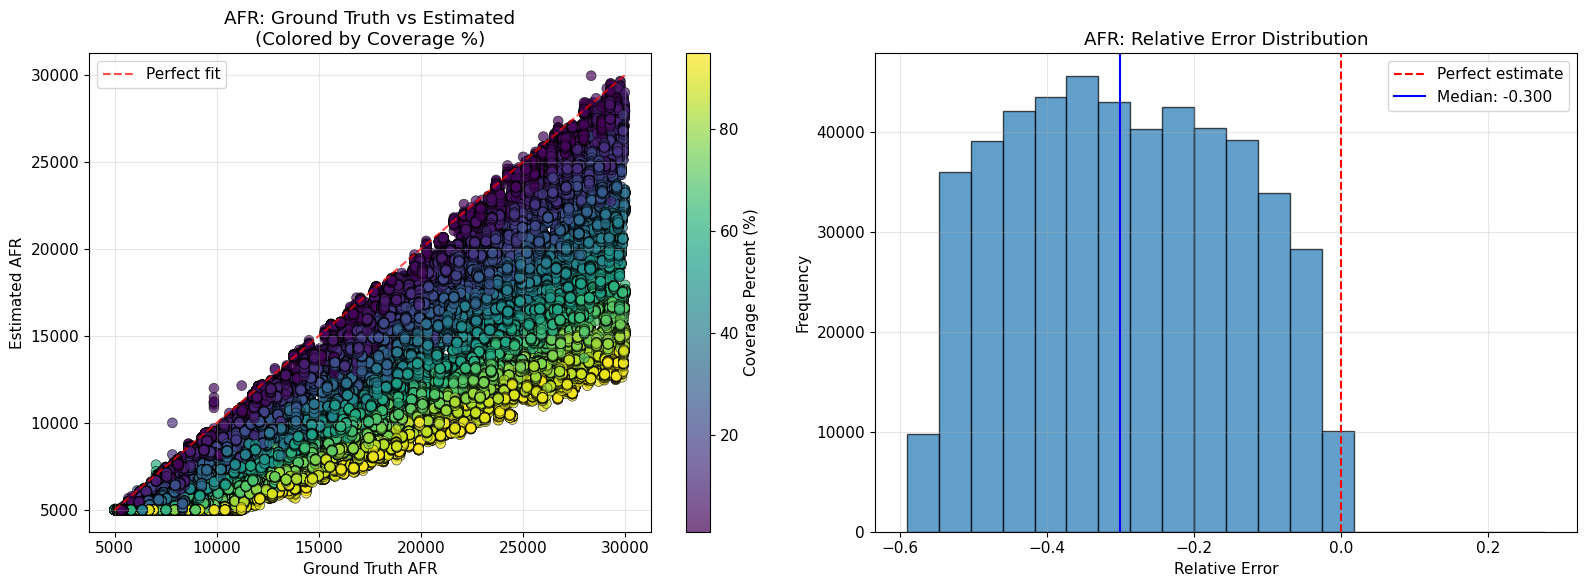


AFR Statistics:
  Estimates: 493428
  Correlation: 0.8637
  RMSE: 6410.6440
  Mean relative error: -0.2947
  Std relative error: 0.1506
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




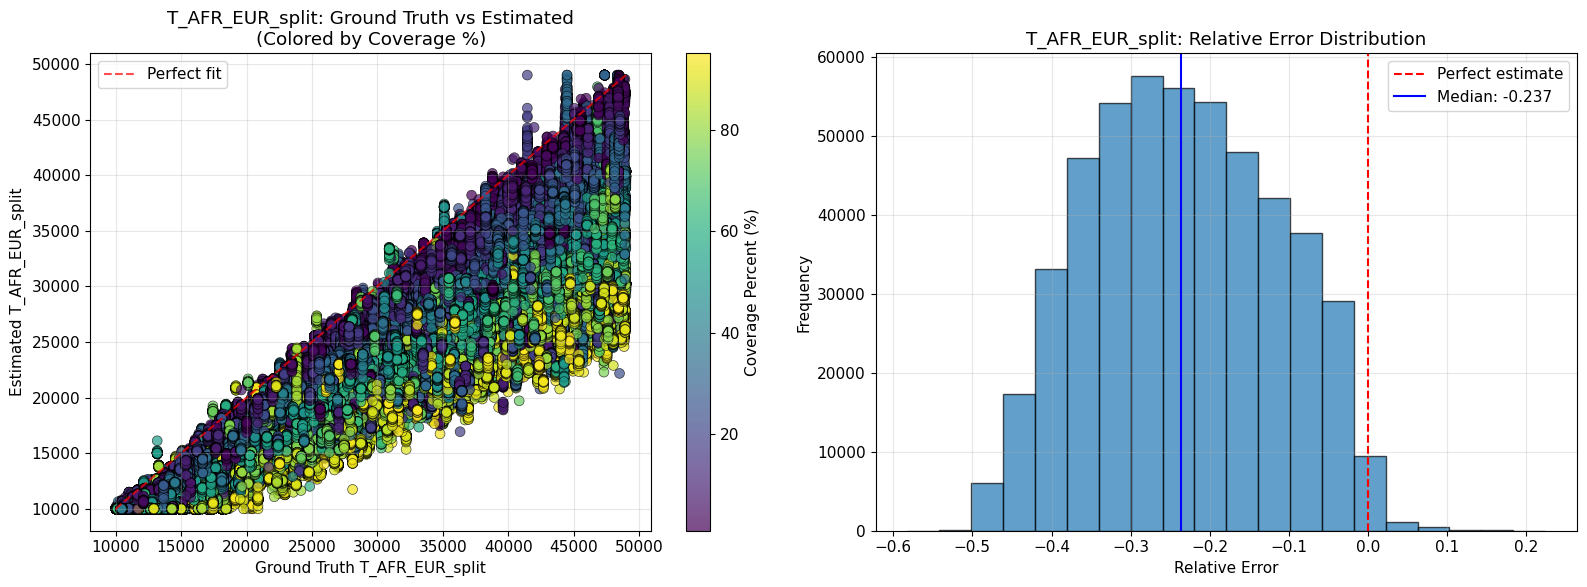


T_AFR_EUR_split Statistics:
  Estimates: 493428
  Correlation: 0.9084
  RMSE: 8746.6655
  Mean relative error: -0.2334
  Std relative error: 0.1178
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




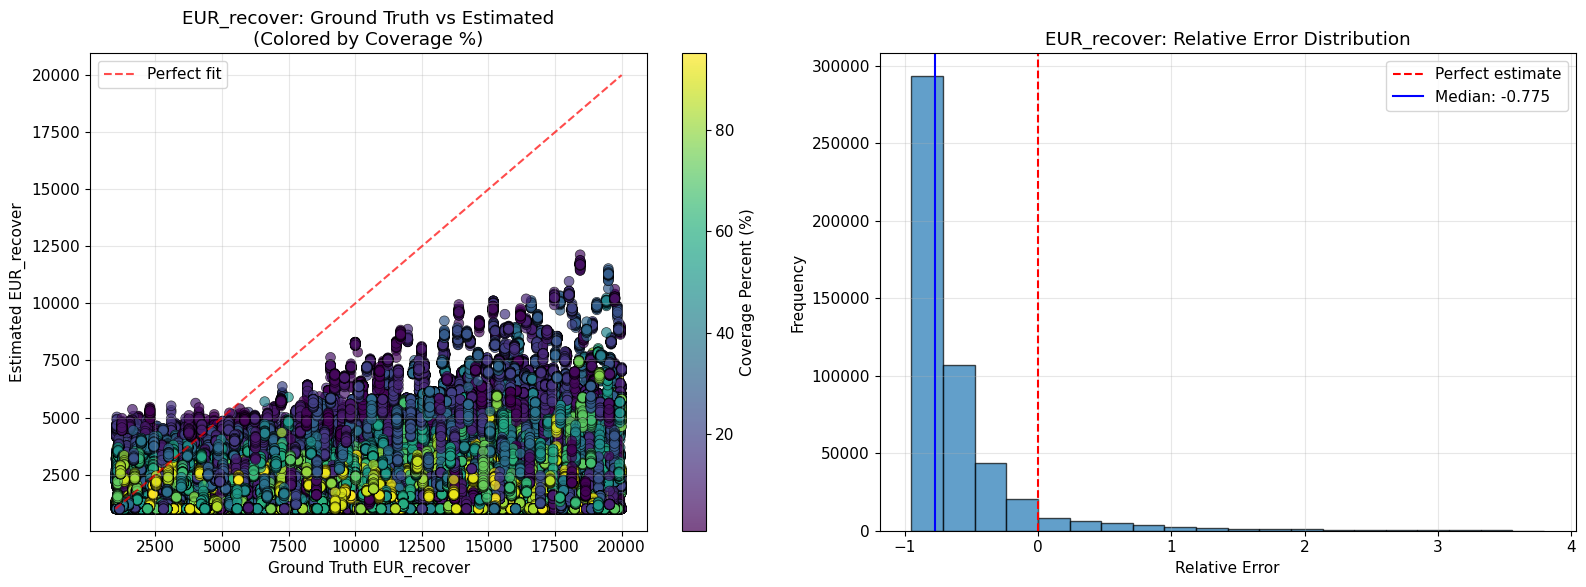


EUR_recover Statistics:
  Estimates: 493428
  Correlation: 0.1464
  RMSE: 9816.6059
  Mean relative error: -0.6393
  Std relative error: 0.4121
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




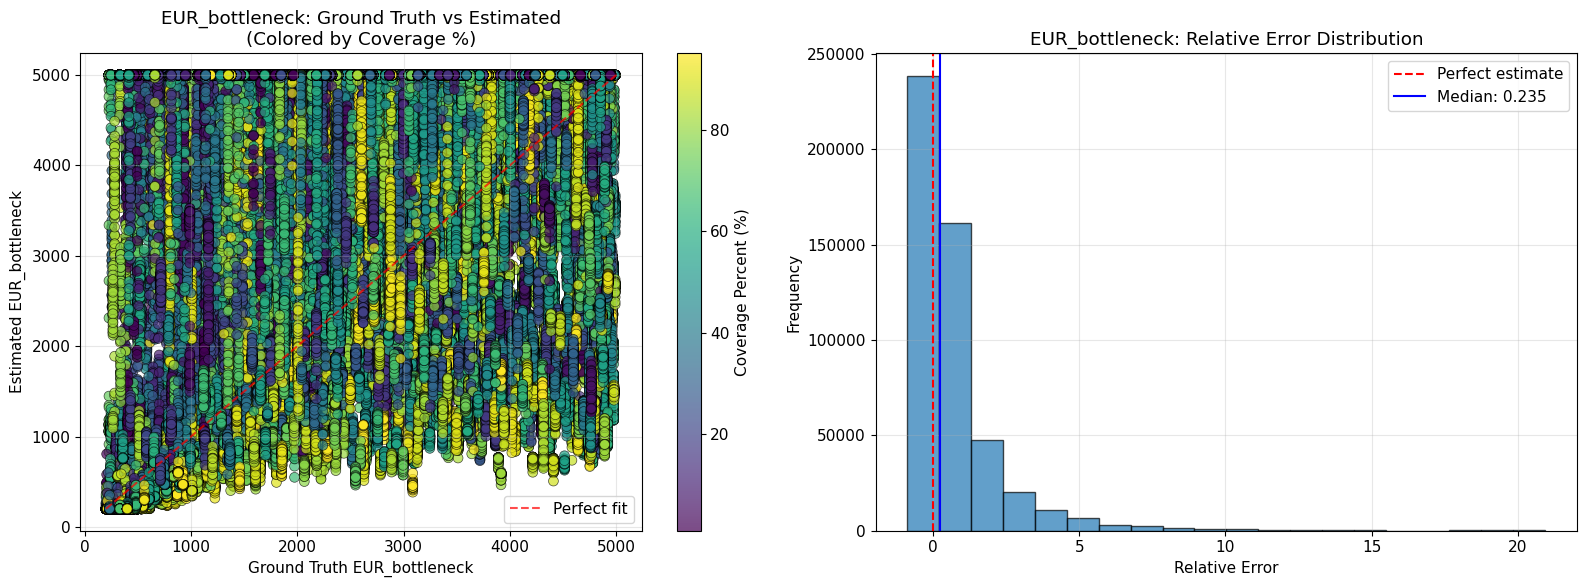


EUR_bottleneck Statistics:
  Estimates: 493428
  Correlation: 0.3934
  RMSE: 1959.5523
  Mean relative error: 0.6970
  Std relative error: 1.5457
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%




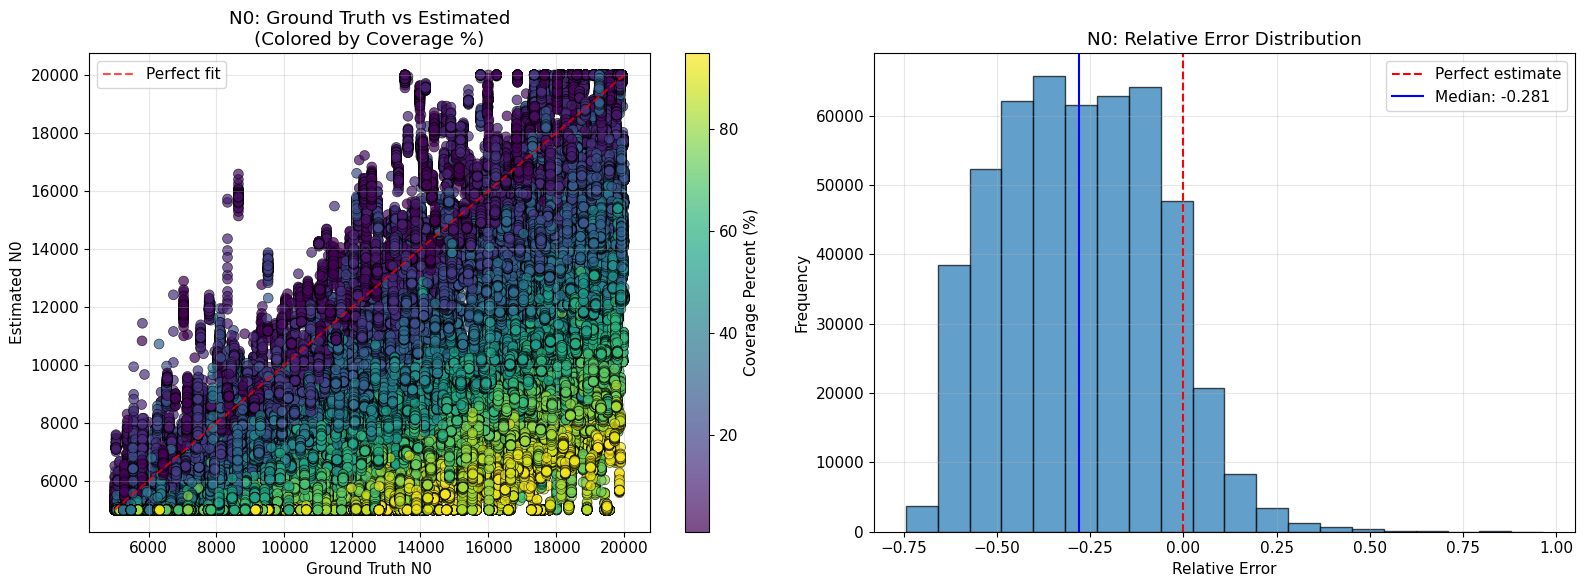


N0 Statistics:
  Estimates: 493428
  Correlation: 0.6694
  RMSE: 5000.9399
  Mean relative error: -0.2777
  Std relative error: 0.2118
  Coverage range: 1.0% - 95.0%
  Mean coverage: 47.5%


Cross-Parameter Analysis:
Not enough migration parameters found for cross-parameter analysis


In [6]:
# Plot parameter comparisons
def plot_parameter(df, param_name):
    """Plot ground truth vs estimated for a parameter, colored by coverage percentage."""
    param_data = df[df['parameter'] == param_name]
    
    if len(param_data) == 0:
        print(f"No data for parameter {param_name}")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot colored by coverage
    coverage = param_data['coverage_percent']
    
    # Handle case where some coverage data might be missing
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = ax1.scatter(param_data[valid_coverage]['ground_truth'], 
                            param_data[valid_coverage]['estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax1)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(param_data):
            ax1.scatter(param_data[~valid_coverage]['ground_truth'], 
                       param_data[~valid_coverage]['estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        ax1.scatter(param_data['ground_truth'], param_data['estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # Identity line
    min_val = min(param_data['ground_truth'].min(), param_data['estimated'].min())
    max_val = max(param_data['ground_truth'].max(), param_data['estimated'].max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='Perfect fit')
    
    ax1.set_xlabel(f'Ground Truth {param_name}')
    ax1.set_ylabel(f'Estimated {param_name}')
    ax1.set_title(f'{param_name}: Ground Truth vs Estimated\n(Colored by Coverage %)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Error histogram
    valid_errors = param_data['relative_error'].dropna()
    if len(valid_errors) > 0:
        ax2.hist(valid_errors, bins=20, alpha=0.7, edgecolor='black')
        ax2.axvline(0, color='red', linestyle='--', label='Perfect estimate')
        ax2.axvline(valid_errors.median(), color='blue', linestyle='-', 
                   label=f'Median: {valid_errors.median():.3f}')
    
    ax2.set_xlabel('Relative Error')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{param_name}: Relative Error Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    valid_data = param_data.dropna(subset=['ground_truth', 'estimated'])
    if len(valid_data) > 0:
        corr = valid_data['ground_truth'].corr(valid_data['estimated'])
        rmse = np.sqrt((valid_data['absolute_error']**2).mean())
        print(f"\n{param_name} Statistics:")
        print(f"  Estimates: {len(valid_data)}")
        print(f"  Correlation: {corr:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
        
        # Coverage-related statistics
        coverage_valid = valid_data['coverage_percent'].notna()
        if coverage_valid.sum() > 0:
            print(f"  Coverage range: {valid_data['coverage_percent'].min():.1f}% - {valid_data['coverage_percent'].max():.1f}%")
            print(f"  Mean coverage: {valid_data['coverage_percent'].mean():.1f}%")

def plot_cross_parameter(df, param1_est, param2_gt, title_suffix=""):
    """Plot estimated param1 vs ground truth param2 to check for parameter confusion, colored by coverage."""
    # Get data for both parameters
    param1_data = df[df['parameter'] == param1_est][['simulation', 'replicate', 'estimated', 'coverage_percent']].rename(columns={'estimated': f'{param1_est}_estimated'})
    param2_data = df[df['parameter'] == param2_gt][['simulation', 'replicate', 'ground_truth']].rename(columns={'ground_truth': f'{param2_gt}_ground_truth'})
    
    # Merge data
    merged_data = pd.merge(param1_data, param2_data, on=['simulation', 'replicate'], how='inner')
    
    if len(merged_data) == 0:
        print(f"No overlapping data for {param1_est} estimated vs {param2_gt} ground truth")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Scatter plot colored by coverage
    coverage = merged_data['coverage_percent']
    valid_coverage = coverage.notna()
    
    if valid_coverage.sum() > 0:
        # Plot points with coverage data
        scatter = plt.scatter(merged_data[valid_coverage][f'{param2_gt}_ground_truth'], 
                            merged_data[valid_coverage][f'{param1_est}_estimated'],
                            c=coverage[valid_coverage], 
                            cmap='viridis', alpha=0.7, s=50, 
                            edgecolors='black', linewidth=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Coverage Percent (%)')
        
        # Plot points without coverage data in gray (if any)
        if valid_coverage.sum() < len(merged_data):
            plt.scatter(merged_data[~valid_coverage][f'{param2_gt}_ground_truth'], 
                       merged_data[~valid_coverage][f'{param1_est}_estimated'],
                       c='gray', alpha=0.5, s=50, 
                       edgecolors='black', linewidth=0.5,
                       label='No coverage data')
    else:
        # If no coverage data available, plot all in single color
        plt.scatter(merged_data[f'{param2_gt}_ground_truth'], merged_data[f'{param1_est}_estimated'], 
                   alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    plt.xlabel(f'Ground Truth {param2_gt}')
    plt.ylabel(f'Estimated {param1_est}')
    plt.title(f'Cross-Parameter Analysis: {param1_est} Estimated vs {param2_gt} Ground Truth{title_suffix}\n(Colored by Coverage %)')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = merged_data[f'{param2_gt}_ground_truth'].corr(merged_data[f'{param1_est}_estimated'])
    plt.text(0.05, 0.95, f'Correlation: {corr:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cross-parameter correlation ({param1_est} est vs {param2_gt} gt): {corr:.4f}")
    print(f"Data points: {len(merged_data)}")
    
    return corr

# Plot each parameter
if not df.empty:
    parameters = [p for p in df['parameter'].unique() if p != 'log_likelihood']
    print(f"Plotting {len(parameters)} parameters: {parameters}")

    for param in parameters:
        plot_parameter(df, param)
        print("\n" + "="*60 + "\n")

    # Cross-parameter analysis
    print("Cross-Parameter Analysis:")
    print("="*50)

    # Check for parameter confusion between migration rates
    available_params = df['parameter'].unique()
    migration_params = [p for p in available_params if 'm' in p.lower() and p != 'log_likelihood']

    if len(migration_params) >= 2:
        print(f"Found migration parameters: {migration_params}")
        
        # Plot m12 estimated vs m21 ground truth (and vice versa)
        for i, param1 in enumerate(migration_params):
            for j, param2 in enumerate(migration_params):
                if i != j:  # Don't compare parameter with itself
                    print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
                    corr = plot_cross_parameter(df, param1, param2)
                    print("-" * 40)
    else:
        print("Not enough migration parameters found for cross-parameter analysis")
        
    # You can also check other parameter pairs
    other_cross_checks = [
        # Add any other parameter pairs you want to check, e.g.:
        # ('N_YRI', 'N_CEU'),
        # ('T_split', 'N_anc'),
    ]

    for param1, param2 in other_cross_checks:
        if param1 in available_params and param2 in available_params:
            print(f"\nAnalyzing: {param1} estimated vs {param2} ground truth")
            plot_cross_parameter(df, param1, param2)
            print("-" * 40)
            
else:
    print("No data available for plotting. Please check that dadi results exist.")

In [7]:
df.shape

(1473800, 8)

In [8]:
# Analysis of NaN values in the dataset
print("NaN Analysis:")
print("="*50)

if not df.empty:
    # Check for NaNs in key columns
    nan_columns = ['ground_truth', 'estimated', 'absolute_error', 'relative_error']
    
    print("NaN counts by column:")
    for col in nan_columns:
        if col in df.columns:
            nan_count = df[col].isna().sum()
            total_count = len(df)
            print(f"  {col}: {nan_count}/{total_count} ({100*nan_count/total_count:.1f}%)")
    
    # Find simulations with at least one NaN in key columns
    sims_with_nan = df.groupby('simulation')[nan_columns].apply(lambda x: x.isna().any().any())
    num_sims_with_nan = sims_with_nan.sum()
    total_sims = len(sims_with_nan)
    
    print(f"\nSimulations with at least one NaN: {num_sims_with_nan}/{total_sims} ({100*num_sims_with_nan/total_sims:.1f}%)")
    
    # Show which simulations have NaNs
    nan_sim_ids = sims_with_nan[sims_with_nan].index.tolist()
    print(f"Simulation IDs with NaNs: {sorted(nan_sim_ids)[:10]}{'...' if len(nan_sim_ids) > 10 else ''}")
    
    # Break down by parameter type
    print(f"\nNaN breakdown by parameter:")
    nan_by_param = df.groupby('parameter')[nan_columns].apply(lambda x: x.isna().any(axis=1).sum())
    for param, nan_count in nan_by_param.items():
        param_total = len(df[df['parameter'] == param])
        print(f"  {param}: {nan_count}/{param_total} rows with NaN ({100*nan_count/param_total:.1f}%)")
    
    # Check if NaNs are in estimated values specifically
    estimated_nan_count = df['estimated'].isna().sum()
    print(f"\nEstimated values that are NaN: {estimated_nan_count}")
    
    if estimated_nan_count > 0:
        print("This suggests optimization failures in dadi/moments!")
        
        # Find which tools are producing NaNs
        if 'parameter' in df.columns:
            nan_rows = df[df['estimated'].isna()]
            # Assuming parameter names contain tool info (like 'dadi_AFR_rep_1')
            tools_with_nan = set()
            for param in nan_rows['parameter'].unique():
                if 'dadi' in param.lower():
                    tools_with_nan.add('dadi')
                elif 'moments' in param.lower():
                    tools_with_nan.add('moments')
            
            print(f"Tools producing NaN estimates: {sorted(tools_with_nan)}")
    
else:
    print("DataFrame is empty - no analysis possible")

NaN Analysis:
NaN counts by column:
  ground_truth: 184225/1473800 (12.5%)
  estimated: 0/1473800 (0.0%)
  absolute_error: 184225/1473800 (12.5%)
  relative_error: 184225/1473800 (12.5%)

Simulations with at least one NaN: 5000/5000 (100.0%)
Simulation IDs with NaNs: ['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005']...

NaN breakdown by parameter:
  AFR: 0/184225 rows with NaN (0.0%)
  EUR_bottleneck: 0/184225 rows with NaN (0.0%)
  EUR_recover: 0/184225 rows with NaN (0.0%)
  N0: 0/184225 rows with NaN (0.0%)
  T_AFR_EUR_split: 0/184225 rows with NaN (0.0%)
  T_AFR_expansion: 0/184225 rows with NaN (0.0%)
  T_EUR_expansion: 0/184225 rows with NaN (0.0%)
  log_likelihood: 184225/184225 rows with NaN (100.0%)

Estimated values that are NaN: 0


Best Estimates Summary (Highest Likelihood per Simulation):

T_OOA_EU_AS:
  Count: 5334
  Mean relative error: -0.0285
  Std relative error: 0.1194
  Within 5%: 2842/5334 (53.3%)
  Within 10%: 4030/5334 (75.6%)

N_OOA:
  Count: 5334
  Mean relative error: 0.0231
  Std relative error: 0.1259
  Within 5%: 4414/5334 (82.8%)
  Within 10%: 5119/5334 (96.0%)

N_CHB:
  Count: 5334
  Mean relative error: -0.0461
  Std relative error: 0.1701
  Within 5%: 1654/5334 (31.0%)
  Within 10%: 2953/5334 (55.4%)

N_anc:
  Count: 5334
  Mean relative error: 0.0072
  Std relative error: 0.0927
  Within 5%: 4856/5334 (91.0%)
  Within 10%: 5176/5334 (97.0%)

N_CEU:
  Count: 5334
  Mean relative error: -0.0433
  Std relative error: 0.1726
  Within 5%: 1698/5334 (31.8%)
  Within 10%: 2941/5334 (55.1%)

T_AFR_OOA:
  Count: 5334
  Mean relative error: 0.0048
  Std relative error: 0.0322
  Within 5%: 5161/5334 (96.8%)
  Within 10%: 5298/5334 (99.3%)

N_YRI:
  Count: 5334
  Mean relative error: 0.0068
  Std relat

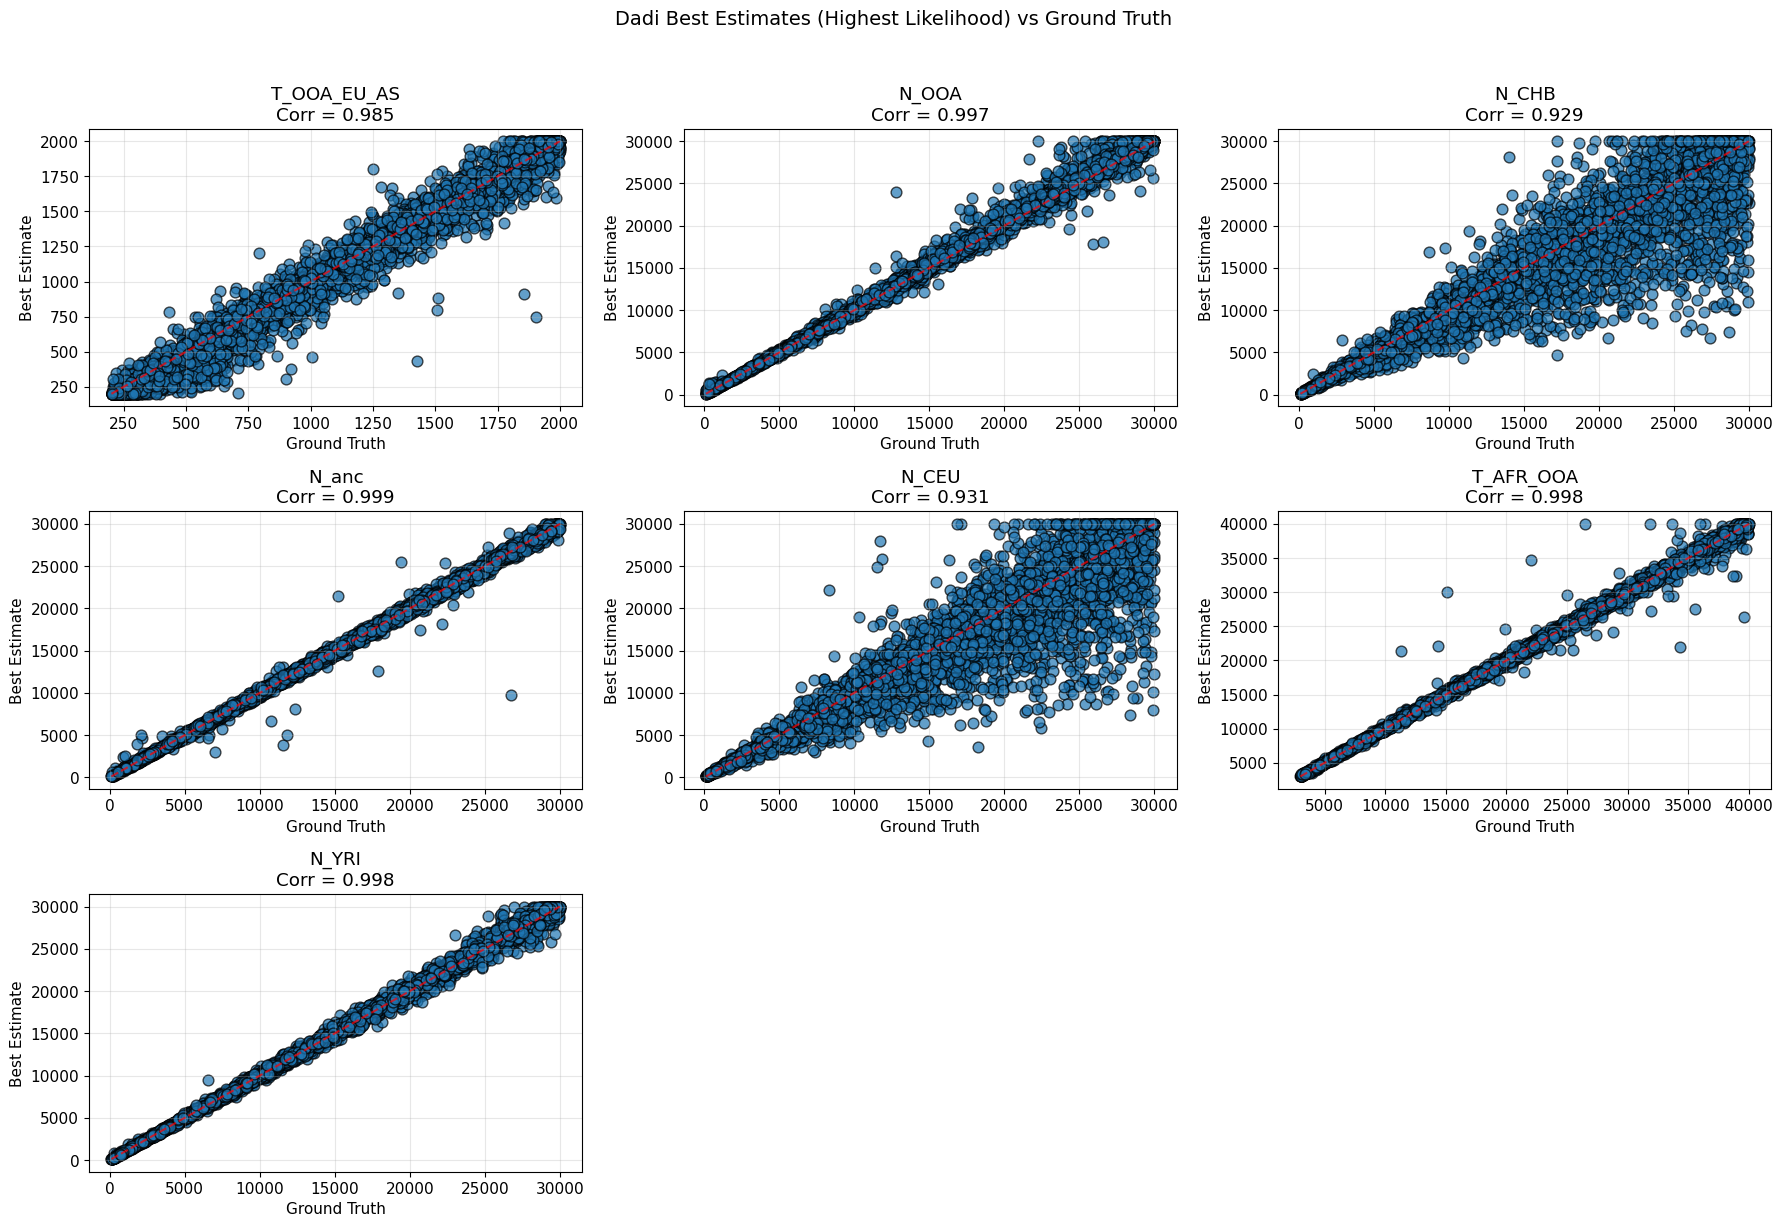

In [7]:
# Best estimates analysis (highest likelihood per simulation)
if not df.empty:
    ll_data = df[df['parameter'] == 'log_likelihood']

    if not ll_data.empty:
        best_estimates = []
        
        for sim_id in ll_data['simulation'].unique():
            sim_ll = ll_data[ll_data['simulation'] == sim_id]
            best_rep = sim_ll.loc[sim_ll['estimated'].idxmax(), 'replicate']
            
            # Get all parameters for this simulation's best replicate
            best_data = df[(df['simulation'] == sim_id) & 
                          (df['replicate'] == best_rep) & 
                          (df['parameter'] != 'log_likelihood')]
            
            for _, row in best_data.iterrows():
                best_estimates.append({
                    'simulation': row['simulation'],
                    'parameter': row['parameter'],
                    'ground_truth': row['ground_truth'],
                    'best_estimate': row['estimated'],
                    'relative_error': row['relative_error'],
                    'coverage_percent': row['coverage_percent']
                })
        
        best_df = pd.DataFrame(best_estimates)
        
        if not best_df.empty:
            print("Best Estimates Summary (Highest Likelihood per Simulation):")
            print("=" * 60)
            
            for param in best_df['parameter'].unique():
                param_data = best_df[best_df['parameter'] == param]
                
                print(f"\n{param}:")
                print(f"  Count: {len(param_data)}")
                print(f"  Mean relative error: {param_data['relative_error'].mean():.4f}")
                print(f"  Std relative error: {param_data['relative_error'].std():.4f}")
                
                # Accuracy within thresholds
                within_5pct = (np.abs(param_data['relative_error']) <= 0.05).sum()
                within_10pct = (np.abs(param_data['relative_error']) <= 0.10).sum()
                total = len(param_data)
                print(f"  Within 5%: {within_5pct}/{total} ({100*within_5pct/total:.1f}%)")
                print(f"  Within 10%: {within_10pct}/{total} ({100*within_10pct/total:.1f}%)")
            
            # Plot best estimates colored by coverage
            params = best_df['parameter'].unique()
            n_params = len(params)
            
            if n_params > 0:
                cols = min(3, n_params)
                rows = (n_params + cols - 1) // cols
                
                fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
                if n_params == 1:
                    axes = [axes]
                elif rows == 1:
                    axes = [axes] if cols == 1 else axes
                else:
                    axes = axes.flatten()
                
                for i, param in enumerate(params):
                    ax = axes[i]
                    param_data = best_df[best_df['parameter'] == param]
                    
                    # Color by coverage if available
                    coverage = param_data['coverage_percent']
                    valid_coverage = coverage.notna()
                    
                    if valid_coverage.sum() > 0:
                        scatter = ax.scatter(param_data[valid_coverage]['ground_truth'], 
                                           param_data[valid_coverage]['best_estimate'],
                                           c=coverage[valid_coverage], 
                                           cmap='viridis', alpha=0.7, s=60, 
                                           edgecolors='black')
                        
                        # Add colorbar for first subplot
                        if i == 0:
                            cbar = plt.colorbar(scatter, ax=ax)
                            cbar.set_label('Coverage %')
                        
                        # Plot points without coverage in gray
                        if valid_coverage.sum() < len(param_data):
                            ax.scatter(param_data[~valid_coverage]['ground_truth'], 
                                     param_data[~valid_coverage]['best_estimate'],
                                     c='gray', alpha=0.5, s=60, 
                                     edgecolors='black')
                    else:
                        ax.scatter(param_data['ground_truth'], param_data['best_estimate'], 
                                  alpha=0.7, s=60, edgecolors='black')
                    
                    # Identity line
                    min_val = min(param_data['ground_truth'].min(), param_data['best_estimate'].min())
                    max_val = max(param_data['ground_truth'].max(), param_data['best_estimate'].max())
                    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
                    
                    # Correlation
                    corr = param_data['ground_truth'].corr(param_data['best_estimate'])
                    ax.set_title(f'{param}\nCorr = {corr:.3f}')
                    ax.set_xlabel('Ground Truth')
                    ax.set_ylabel('Best Estimate')
                    ax.grid(True, alpha=0.3)
                
                # Hide unused subplots
                for i in range(n_params, len(axes)):
                    axes[i].set_visible(False)
                
                plt.suptitle('Dadi Best Estimates (Highest Likelihood) vs Ground Truth', 
                            fontsize=14, y=1.02)
                plt.tight_layout()
                plt.show()
        
    else:
        print("No likelihood data found - cannot identify best estimates")
        
else:
    print("No data available for best estimates analysis")

In [14]:
# Summary statistics by parameter
if not df.empty:
    print("Overall Parameter Statistics:")
    print("=" * 50)

    for param in [p for p in df['parameter'].unique() if p != 'log_likelihood']:
        param_data = df[df['parameter'] == param]
        
        print(f"\n{param}:")
        print(f"  Total estimates: {len(param_data)}")
        print(f"  Simulations: {len(param_data['simulation'].unique())}")
        
        valid_errors = param_data['relative_error'].dropna()
        if len(valid_errors) > 0:
            print(f"  Mean relative error: {valid_errors.mean():.4f}")
            print(f"  Median relative error: {valid_errors.median():.4f}")
            print(f"  Std relative error: {valid_errors.std():.4f}")
            
            # Percentiles
            p25, p75 = np.percentile(np.abs(valid_errors), [25, 75])
            print(f"  25th percentile |error|: {p25:.4f}")
            print(f"  75th percentile |error|: {p75:.4f}")

    print("\n" + "="*50)
    print("Dadi analysis complete!")
    
else:
    print("No data available for statistical analysis.")
    print("Please check:")
    print("  1. Dadi results exist in the runs/run_*/inferences/dadi/ directories")
    print("  2. Parameter names in dadi results match ground truth parameter names")
    print("  3. Result files contain properly formatted parameter data")

Overall Parameter Statistics:

t_bottleneck_end:
  Total estimates: 92
  Simulations: 92
  Mean relative error: -0.0103
  Median relative error: 0.0008
  Std relative error: 0.1132
  25th percentile |error|: 0.0127
  75th percentile |error|: 0.0972

N_recover:
  Total estimates: 92
  Simulations: 92
  Mean relative error: 0.1207
  Median relative error: 0.0718
  Std relative error: 0.2646
  25th percentile |error|: 0.0490
  75th percentile |error|: 0.1562

N_bottleneck:
  Total estimates: 92
  Simulations: 92
  Mean relative error: -0.0000
  Median relative error: 0.0000
  Std relative error: 0.0000
  25th percentile |error|: 0.0000
  75th percentile |error|: 0.0000

t_bottleneck_start:
  Total estimates: 92
  Simulations: 92
  Mean relative error: 0.0105
  Median relative error: 0.0141
  Std relative error: 0.0495
  25th percentile |error|: 0.0146
  75th percentile |error|: 0.0503

N0:
  Total estimates: 92
  Simulations: 92
  Mean relative error: -0.0000
  Median relative error: 0.00